Importing all the necessary libraries and functions used further.

In [1]:
import requests
import pandas as pd
from datetime import datetime
import time
import requests
import pandas as pd
from datetime import datetime
import time
import io
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.models import load_model


Defining a function fetch_stock_data that makes use of web scraping to fetch historical stock data from yahoo finance for a specific company that the users chooses (for demonstration purposes we are currently using stock data for Apple(AAPL)).
The data is then saved to an Excel file in the save_to_excel function which are both being called by the main function 

In [2]:
def fetch_stock_data(stock_name):
    end_date = int(datetime.now().timestamp())
    start_date = int((datetime.now() - pd.DateOffset(days=1826)).timestamp())

    url = f"https://query1.finance.yahoo.com/v7/finance/download/{stock_name}?period1={start_date}&period2={end_date}&interval=1d&events=history"
    headers = {
        "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/94.0.4606.81 Safari/537.36"
    }

    retries = 3
    while retries > 0:
        try:
            response = requests.get(url, headers=headers)
            if response.status_code == 200:
                stock_data = pd.read_csv(io.StringIO(response.text))
                return stock_data
            else:
                print("Failed to fetch data")
                print(f"Status Code: {response.status_code}")
                return None
        except requests.RequestException as e:
            print(f"Request failed: {e}")
            retries -= 1
            time.sleep(2)  # Wait before retrying

    print("Maximum retries exceeded. Unable to fetch data.")
    return None

def save_to_excel(stock_data, stock_name):
    if stock_data is not None:
        stock_data.to_excel(f"Historical Data/{stock_name}.xlsx", index=False)
        print(f"Stock data for {stock_name} saved successfully to the Excel file.")

if __name__ == "__main__":
    stock_name = input("Enter the stock ticker symbol: ")
    data = fetch_stock_data(stock_name)
    if data is not None:
        save_to_excel(data, stock_name)
    else:
        print("Data retrieval failed or invalid ticker symbol provided.")


Stock data for MSFT saved successfully to the Excel file.


Now we can define a dataframe that reads the excel file and we can do some data analysis on the existing data to identify what parameters we want to train our LSTM model on.
Firstly we analyze the Adjusted Close and Volume trends for the company by making various plots

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1259 non-null   object 
 1   Open       1259 non-null   float64
 2   High       1259 non-null   float64
 3   Low        1259 non-null   float64
 4   Close      1259 non-null   float64
 5   Adj Close  1259 non-null   float64
 6   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


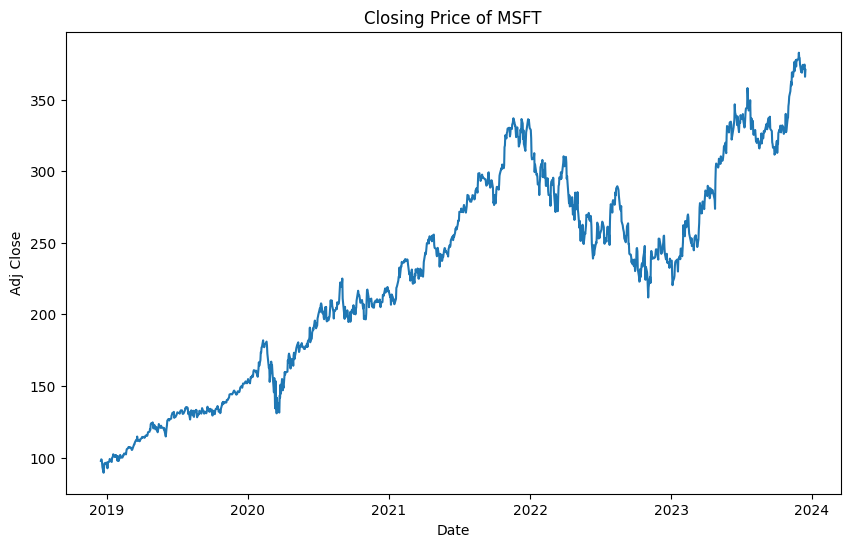

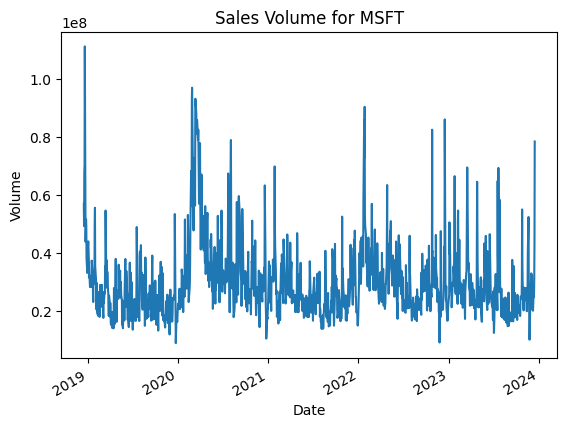

In [3]:

df=pd.read_excel(f"Historical Data/{stock_name}.xlsx")
df.describe()
df.info()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)  # Set 'Date' column as the index

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
plt.plot(df['Adj Close'])
plt.ylabel('Adj Close')
plt.xlabel('Date')
plt.title(f'Closing Price of {stock_name}')
plt.show()
df['Volume'].plot()
plt.ylabel('Volume')
plt.xlabel('Date')
plt.title(f"Sales Volume for {stock_name}")
plt.show()

Now we identify the daily return of the stock by using .pct_change() function which tells us how much of a daily difference here was in the adjusted close price  

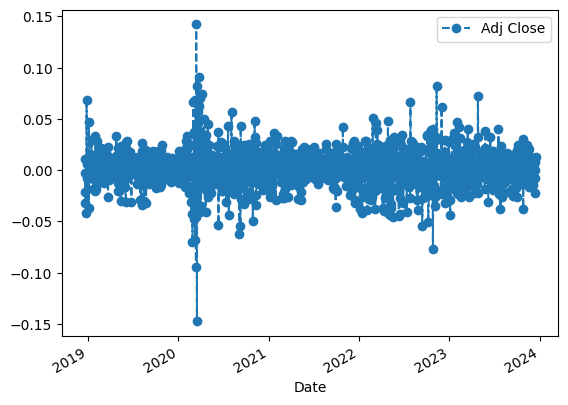

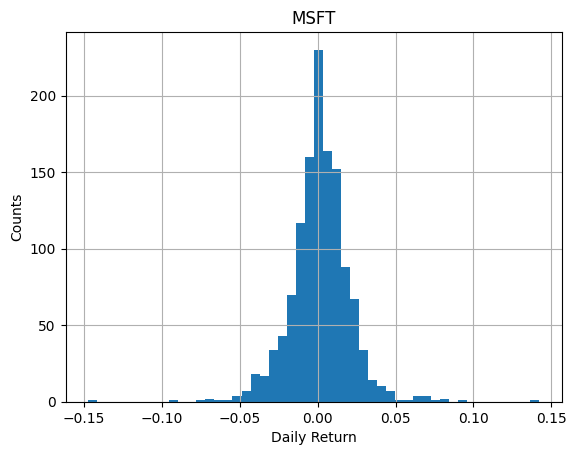

In [4]:
df_daily_return = df['Adj Close'].pct_change()
df_daily_return
df_daily_return.plot( legend=True, linestyle='--', marker='o')
plt.show()
df_daily_return.hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title(f'{stock_name}')
plt.show()


Now we plot the moving average for the stock over 10,20 and 50 days.

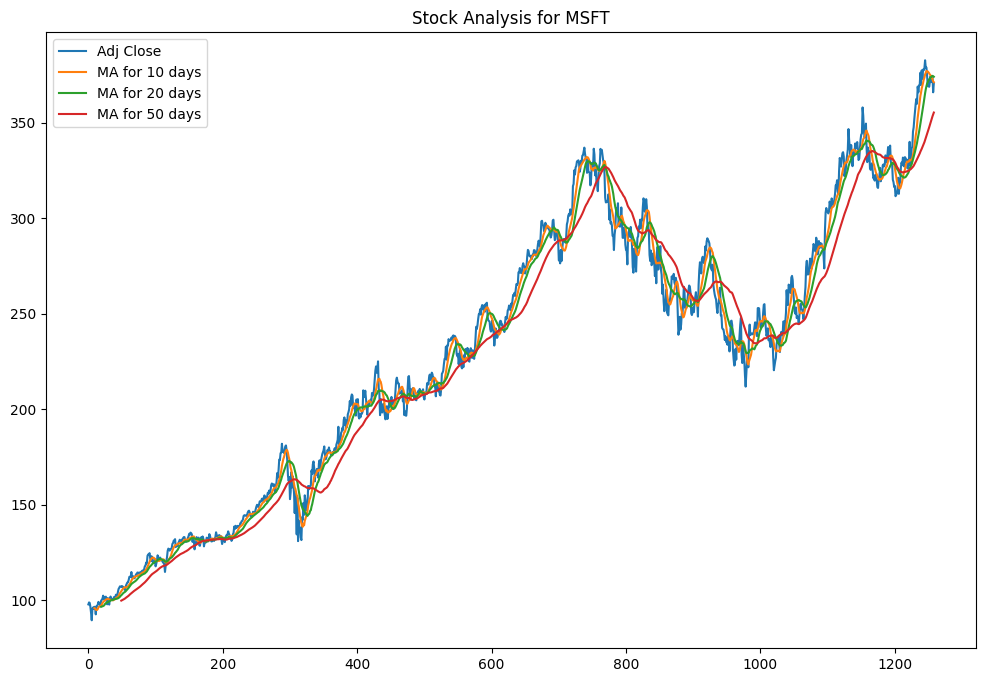

In [5]:


moving_avg = pd.read_excel(f"Historical Data/{stock_name}.xlsx")

ma_day = [10, 20, 50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    moving_avg[column_name] = moving_avg['Adj Close'].rolling(ma).mean()

fig, axes = plt.subplots(nrows=1, ncols=1)
fig.set_figheight(8)
fig.set_figwidth(12)

moving_avg[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot(ax=axes)
axes.set_title(f'Stock Analysis for {stock_name}')

# Adjust spacing between subplots here
plt.subplots_adjust(wspace=0.3, hspace=0.3)  # You can modify these values as needed

plt.show()

Finally we plot the expected return and the risk involved in investing the partiular stock

Text(50, 50, 'Adj Close')

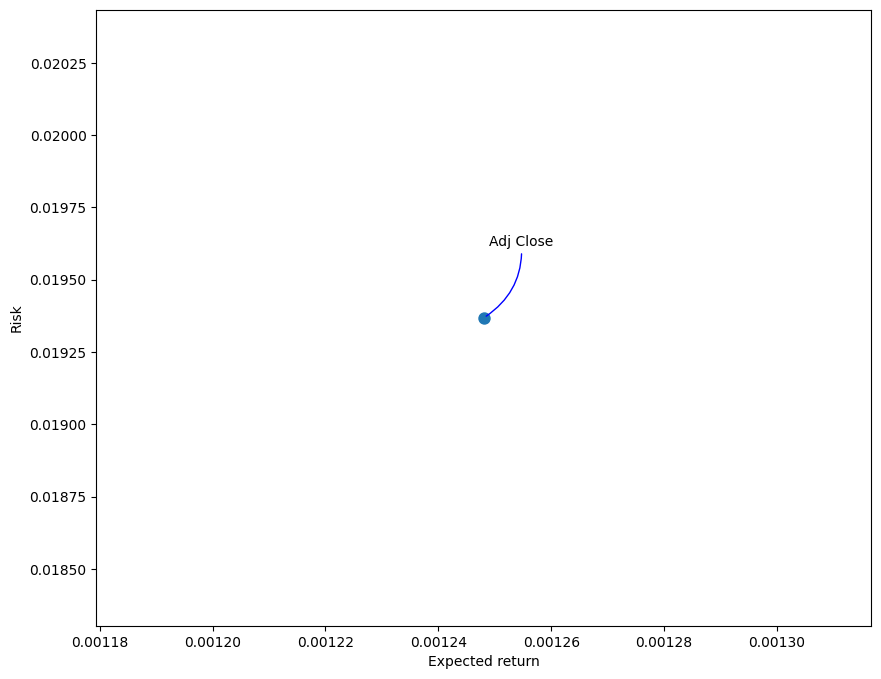

In [6]:
closing_df = pd.read_excel(f"Historical Data/{stock_name}.xlsx")
column_name = 'Adj Close'
closing_df[column_name] = closing_df['Adj Close']
closing_df['Adj Close'] = pd.to_numeric(closing_df['Adj Close'], errors='coerce')
closing_df.dropna(subset=['Adj Close'], inplace=True)

tech_return = closing_df['Adj Close'].pct_change()
rets = tech_return.dropna()

area = np.pi * 20

plt.figure(figsize=(10, 8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected return')
plt.ylabel('Risk')

plt.annotate(rets.name, xy=(rets.mean(), rets.std()), xytext=(50, 50), textcoords='offset points', ha='right', va='bottom',
             arrowprops=dict(arrowstyle='-', color='blue', connectionstyle='arc3,rad=-0.3'))

Now we select the 'Adj Close' column to train our LSTM on, we would try and predict the future pries of the stock based on this data, we select this as our training data.

In [7]:
training_data=pd.read_excel(f'Historical Data/{stock_name}.xlsx')['Adj Close']
training_data

0        97.704048
1        98.729614
2        98.463707
3        96.393608
4        93.278915
           ...    
1254    371.299988
1255    374.380005
1256    374.369995
1257    365.929993
1258    370.730011
Name: Adj Close, Length: 1259, dtype: float64

We now have to reshape the data to fit in our lstm model, we first change the model shape to a numpy array of size(-1,1) and then use min ax scaller to transform the data to shape (0,1) which will then go into our LSTM

In [8]:
scaled_data = training_data.values.reshape(-1, 1)
scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(scaled_data)
scaled_data

array([[0.02836026],
       [0.03185673],
       [0.03095017],
       ...,
       [0.97160039],
       [0.9428258 ],
       [0.95919055]])

Defining a feature set array that stores 

In [9]:
features_set = []
labels = []
for i in range(60, len(scaled_data)):
    features_set.append(scaled_data[i-60:i, 0])
    labels.append(scaled_data[i, 0])
features_set, labels = np.array(features_set), np.array(labels)


In [10]:
features_set = np.reshape(features_set, (features_set.shape[0], features_set.shape[1], 1))


In [11]:
# Create a new array containing scaled values from index 1543 to 2002
df=pd.read_excel(f'Historical Data/{stock_name}.xlsx')
data=df.filter(['Close'])
dataset=data.values
train_dataset_len=int(np.ceil(len(dataset)*.85))
test_data = scaled_data[train_dataset_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[train_dataset_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [13]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error
from keras.callbacks import ModelCheckpoint

def create_lstm_model():
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True, input_shape=(features_set.shape[1], 1)))
    model.add(Dropout(0.65))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.40))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.40))
    model.add(LSTM(units=32))
    model.add(Dropout(0.40))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Assuming you have scaled_data available
input_shape = (scaled_data.shape[1], 1)

# Create the LSTM model
lstm_model = create_lstm_model()

validation_split = 0.2 
split_index = int(len(features_set) * (1 - validation_split))
train_features, val_features = features_set[:split_index], features_set[split_index:]
train_labels, val_labels = labels[:split_index], labels[split_index:]

mc = ModelCheckpoint(f'LSTM({stock_name}).hdf5', monitor='loss', verbose=1, save_best_only=True, mode='min')
# Train the model
history = lstm_model.fit(features_set, labels, epochs=700, batch_size=392,callbacks=[mc],validation_data=(val_features, val_labels))



Epoch 1/700
4/4 [==============================] - ETA: 0s - loss: 0.1702
Epoch 1: loss improved from inf to 0.17017, saving model to LSTM(MSFT).hdf5
4/4 [==============================] - 9s 903ms/step - loss: 0.1702 - val_loss: 0.0695
Epoch 2/700


c:\Users\rking\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4/4 [==============================] - ETA: 0s - loss: 0.0616
Epoch 2: loss improved from 0.17017 to 0.06162, saving model to LSTM(MSFT).hdf5
4/4 [==============================] - 2s 402ms/step - loss: 0.0616 - val_loss: 0.0577
Epoch 3/700
4/4 [==============================] - ETA: 0s - loss: 0.0403
Epoch 3: loss improved from 0.06162 to 0.04025, saving model to LSTM(MSFT).hdf5
4/4 [==============================] - 2s 380ms/step - loss: 0.0403 - val_loss: 0.0645
Epoch 4/700
4/4 [==============================] - ETA: 0s - loss: 0.0282
Epoch 4: loss improved from 0.04025 to 0.02815, saving model to LSTM(MSFT).hdf5
4/4 [==============================] - 2s 385ms/step - loss: 0.0282 - val_loss: 0.0048
Epoch 5/700
4/4 [==============================] - ETA: 0s - loss: 0.0261
Epoch 5: loss improved from 0.02815 to 0.02614, saving model to LSTM(MSFT).hdf5
4/4 [==============================] - 2s 410ms/step - loss: 0.0261 - val_loss: 0.0043
Epoch 6/700
4/4 [==============================]

In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, confusion_matrix
predictions = lstm_model.predict(features_set)
mse = mean_squared_error(labels, predictions)
mae = mean_absolute_error(labels, predictions)
r2 = r2_score(labels, predictions)
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared Score: {r2}')

38/38 [==============================] - 5s 58ms/step
Mean Squared Error: 0.0007691439824590859
Mean Absolute Error: 0.021790826582872538
R-squared Score: 0.9861671106158275


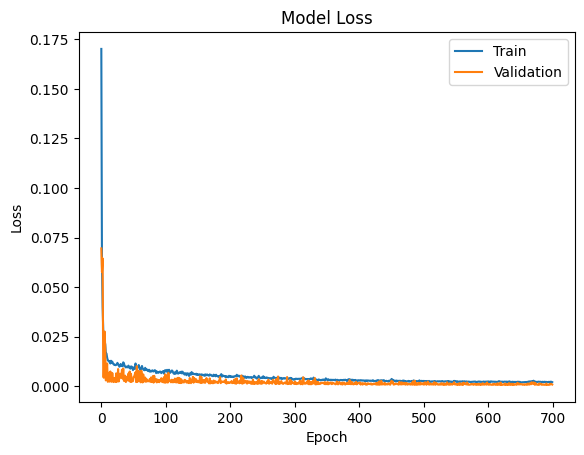

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

6/6 [==============================] - 2s 47ms/step


C:\Users\rking\AppData\Local\Temp\ipykernel_4512\148972974.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


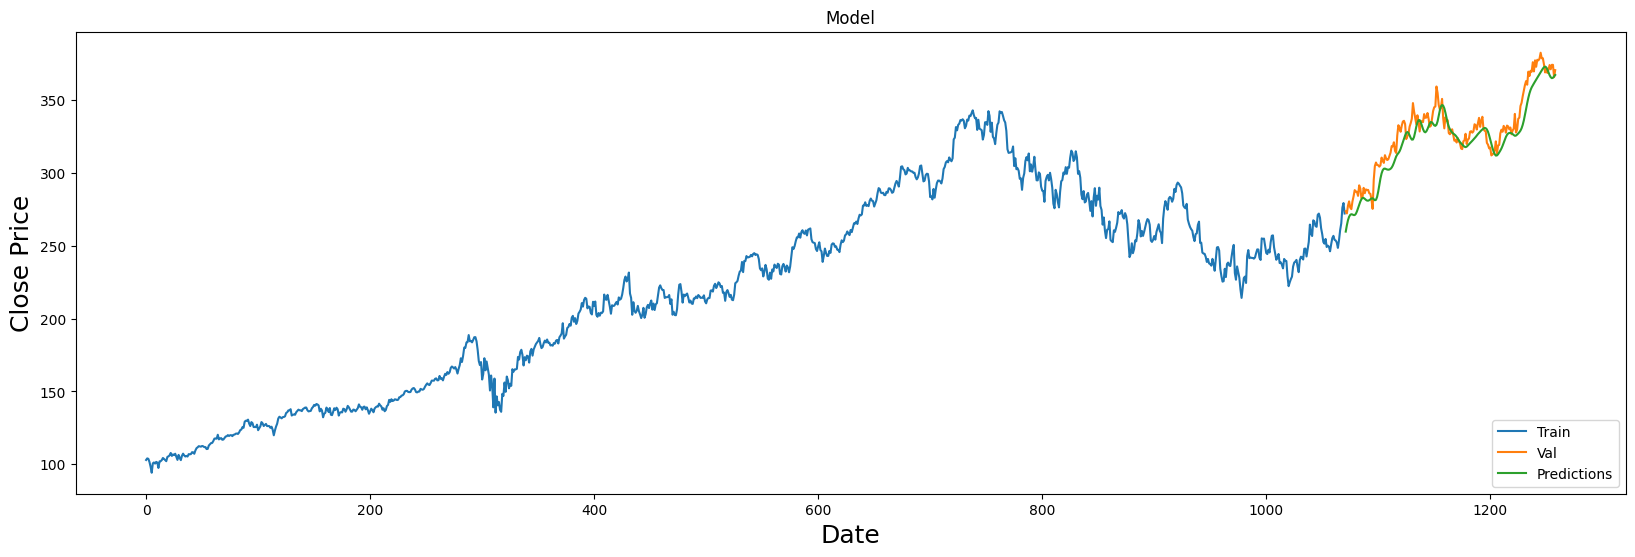

[[259.79752]
 [264.12213]
 [267.6428 ]
 [269.98428]
 [271.28894]
 [271.73962]
 [271.54562]
 [271.171  ]
 [271.15826]
 [271.97775]
 [273.6887 ]
 [275.99542]
 [278.30884]
 [280.38846]
 [282.04303]
 [282.91443]
 [282.87564]
 [282.32608]
 [281.6141 ]
 [281.11273]
 [281.0299 ]
 [281.3915 ]
 [281.98474]
 [282.54297]
 [282.71655]
 [282.0868 ]
 [281.34094]
 [281.61533]
 [283.652  ]
 [287.3437 ]
 [291.92975]
 [296.35495]
 [299.77045]
 [301.96375]
 [303.00116]
 [303.0866 ]
 [302.76566]
 [302.45056]
 [302.33313]
 [302.4727 ]
 [302.92294]
 [303.77078]
 [305.16687]
 [307.05524]
 [309.30173]
 [311.38306]
 [312.76517]
 [313.70395]
 [314.8824 ]
 [316.6556 ]
 [318.8487 ]
 [321.22858]
 [323.61508]
 [325.82397]
 [327.57452]
 [328.22913]
 [327.58746]
 [325.96933]
 [324.16638]
 [322.99884]
 [323.05576]
 [324.90005]
 [328.20184]
 [331.92535]
 [334.81183]
 [336.3523 ]
 [336.38773]
 [334.91232]
 [332.57086]
 [330.22058]
 [328.5138 ]
 [328.0089 ]
 [328.72034]
 [330.2832 ]
 [332.29297]
 [334.13483]
 [335.0975 ]

In [17]:


model=load_model(f'LSTM({stock_name}).hdf5')
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
train = data[:train_dataset_len]
valid = data[train_dataset_len:]
valid_values=valid.values
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(20,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
print(predictions)
print(rmse)

model.summary()

1/1 [==============================] - 0s 63ms/step


C:\Users\rking\AppData\Local\Temp\ipykernel_4512\3836994191.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x_test[0, -1, 0] = prediction


1/1 [==============================] - 0s 62ms/step


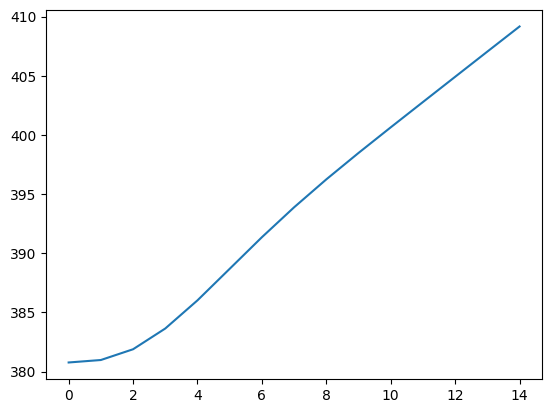

In [18]:
# Assuming test_data contains the last 60 days of the available data
x_test = []
x_test.append(test_data[-60:])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
predictions = []

for _ in range(15):
        # Predict the next day
        prediction = lstm_model.predict(x_test)
        
        # Append the prediction to the results
        predictions.append(prediction[0, 0])

        # Update x_test for the next prediction
        x_test = np.roll(x_test, -1, axis=1)
        x_test[0, -1, 0] = prediction

    # Inverse transform the predictions to get actual stock prices
predictions = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))
plt.plot(predictions)

In [19]:
print(predictions)

[[380.77182]
 [380.98026]
 [381.8893 ]
 [383.64288]
 [386.02325]
 [388.68903]
 [391.359  ]
 [393.88687]
 [396.2469 ]
 [398.48053]
 [400.6453 ]
 [402.78412]
 [404.91745]
 [407.04803]
 [409.17038]]
